# TOPIX

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import yfinance as yf

import pymc as pm
from pymc_experimental.statespace import structural as st
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
# TOPIXの価格データを取得
topix = yf.download('^TOPX', start='2014-11-29', end='2024-11-29')
topix['log_adj_close'] = np.log(topix['Adj Close'])
# データの先頭を表示
topix.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,log_adj_close
Ticker,^TOPX,^TOPX,^TOPX,^TOPX,^TOPX,^TOPX,
Date,,,,,,,
2014-12-01,1421.650024,1421.650024,1427.119995,1413.599976,1413.599976,202400,7.259573
2014-12-02,1427.849976,1427.849976,1429.489990,1414.000000,1414.000000,201400,7.263925
2014-12-03,1429.750000,1429.750000,1440.670044,1427.229980,1435.979980,251900,7.265255
2014-12-04,1440.599976,1440.599976,1443.329956,1437.040039,1441.459961,223900,7.272815
2014-12-05,1445.670044,1445.670044,1445.770020,1433.880005,1438.900024,207000,7.276328


In [3]:
topix.describe()

Price,Adj Close,Close,High,Low,Open,Volume,log_adj_close
Ticker,^TOPX,^TOPX,^TOPX,^TOPX,^TOPX,^TOPX,
count,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1.598000e+03,1598.000000
mean,1609.080449,1609.080449,1617.081001,1600.529594,1609.236159,2.120443e+05,7.377555
std,173.596584,173.596584,172.802794,174.547132,173.704475,1.311732e+06,0.108663
min,1196.280029,1196.280029,1227.160034,1192.800049,1208.569946,0.000000e+00,7.086972
25%,1506.780029,1506.780029,1515.445007,1498.574982,1507.945038,0.000000e+00,7.317730
50%,1604.559998,1604.559998,1610.804993,1594.975037,1603.359985,0.000000e+00,7.380605
75%,1724.632507,1724.632507,1730.375031,1715.535034,1722.129944,1.158750e+05,7.452769
max,2030.160034,2030.160034,2041.819946,2023.599976,2040.000000,1.551000e+07,7.615870


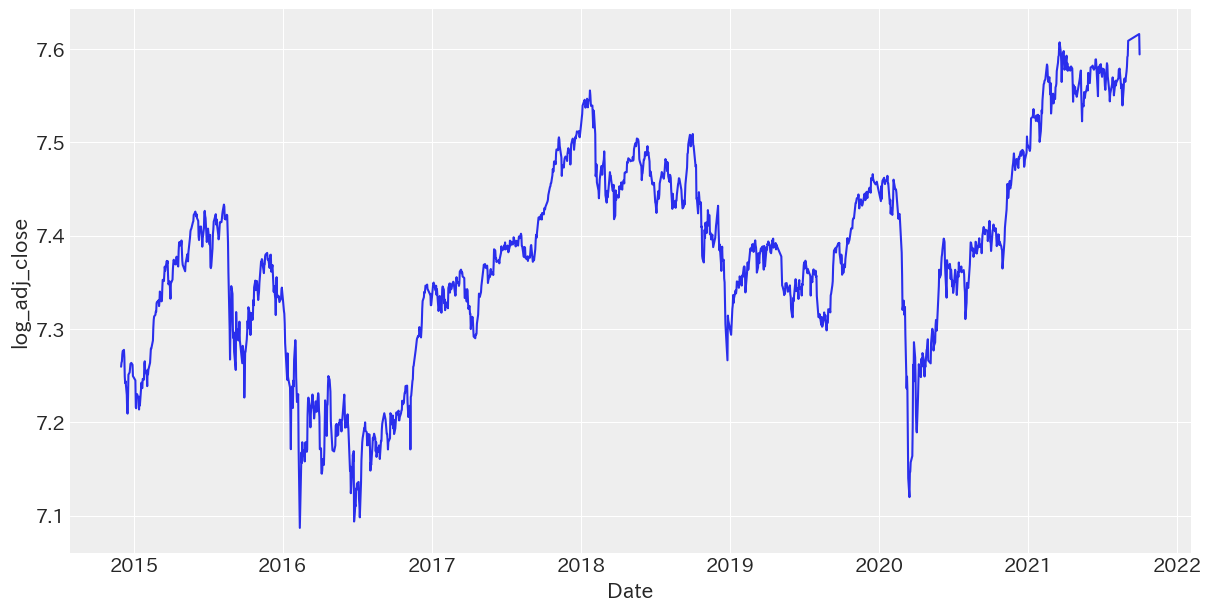

In [4]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=topix, x='Date', y='log_adj_close')
plt.show()

## Local Level Model

$$
\begin{aligned}
\mu_t &= \mu_{t-1} + w_t, \quad w_t \sim \mathcal{N}(0, \sigma_u^2) \\
y_t &= \mu_t + v_t, \quad v_t \sim \mathcal{N}(0, \sigma_{v}^2)
\end{aligned}
$$

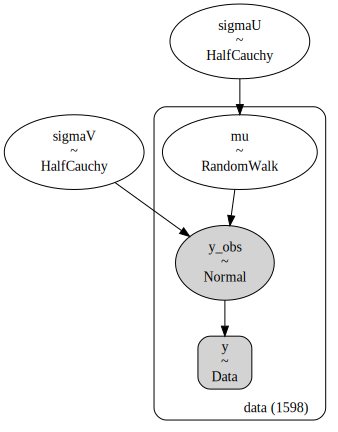

In [34]:
with pm.Model() as local_level_model:
    # coord
    local_level_model.add_coord('data', values=topix.index)

    # data
    y = pm.Data('y', topix['log_adj_close'].dropna(), dims='data')

    # prior
    sigmaU = pm.HalfCauchy('sigmaU', 0.1)
    sigmaV = pm.HalfCauchy('sigmaV', 0.1)

    init_dist = pm.Normal.dist(mu=0, sigma=1)
    mu = pm.GaussianRandomWalk('mu', sigma=sigmaU, init_dist=init_dist, dims='data')

    # likelihood
    y_obs = pm.Normal('y_obs', mu, sigmaV, observed=y, dims='data')

pm.model_to_graphviz(local_level_model)

In [38]:
with local_level_model:
    trace_local_level_model = pm.sample(
        draws=5000,
        tune=4000,
        chains=4,
        # target_accept=.95,
        nuts_sampler='numpyro'
    )

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [40]:
az.summary(trace_local_level_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[2014-12-01T00:00:00.000000000],7.260,0.001,7.257,7.262,0.0,0.0,28275.0,209.0,1.23
mu[2014-12-02T00:00:00.000000000],7.264,0.001,7.261,7.267,0.0,0.0,30254.0,204.0,1.23
mu[2014-12-03T00:00:00.000000000],7.265,0.001,7.263,7.268,0.0,0.0,27944.0,190.0,1.24
mu[2014-12-04T00:00:00.000000000],7.273,0.001,7.270,7.276,0.0,0.0,27063.0,206.0,1.22
mu[2014-12-05T00:00:00.000000000],7.276,0.001,7.273,7.279,0.0,0.0,28279.0,174.0,1.23
...,...,...,...,...,...,...,...,...,...
mu[2021-09-03T00:00:00.000000000],7.608,0.001,7.606,7.611,0.0,0.0,23109.0,191.0,1.22
mu[2021-09-30T00:00:00.000000000],7.616,0.001,7.612,7.618,0.0,0.0,275.0,179.0,1.21
mu[2021-10-01T00:00:00.000000000],7.594,0.001,7.592,7.597,0.0,0.0,710.0,177.0,1.23
sigmaU,0.012,0.000,0.012,0.012,0.0,0.0,40.0,364.0,1.06


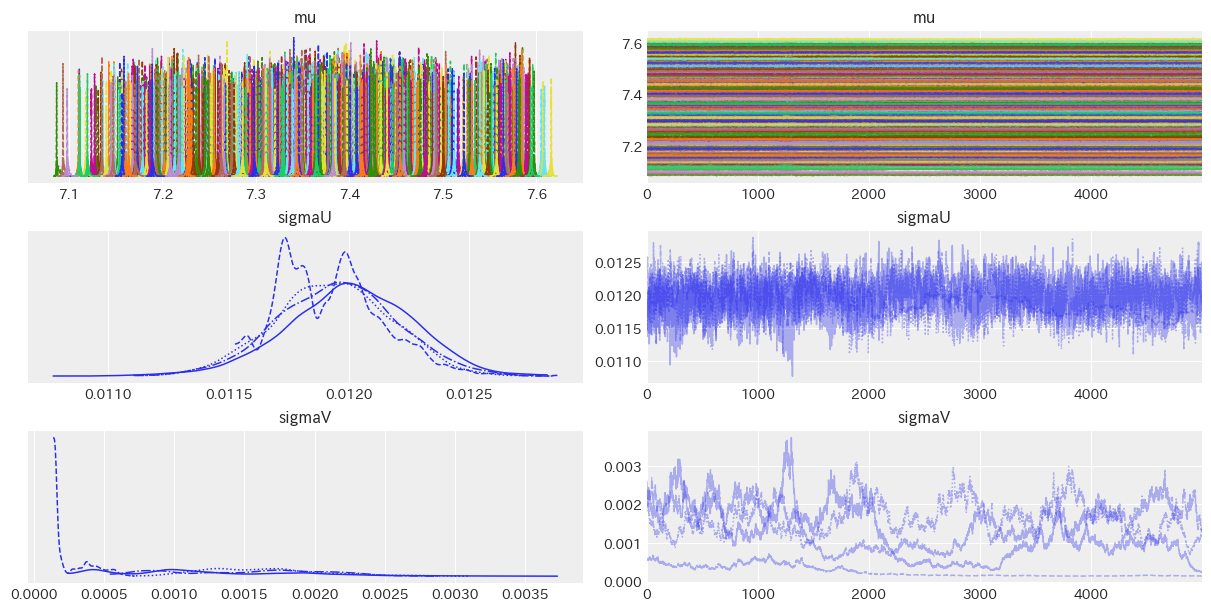

In [41]:
az.plot_trace(trace_local_level_model);

## Local linear trend model

$$
\begin{aligned}
\delta_t &= \delta_{t-1} + ξ_t, \quad ξ_t \sim \mathcal{N}(0, \sigma_w^2) \\
\mu_t &= \mu_{t-1} + \delta_{t-1} + w_t, \quad w_t \sim \mathcal{N}(0, \sigma_u^2) \\
y_t &= \mu_t + v_t, \quad v_t \sim \mathcal{N}(0, \sigma_{v}^2)
\end{aligned}
$$

In [18]:
t = len(topix['log_adj_close'])
t

1598

In [15]:
with pm.Model() as local_linear_trend_model:
    # data
    y = pm.Data('y', topix['log_adj_close'], shape=t)

    # prior
    sigmaξ = pm.HalfCauchy('sigmaξ', 0.1)
    sigmaW = pm.HalfCauchy('sigmaW', 0.1)
    sigmaV = pm.HalfCauchy('sigmaV', 0.1)

    delta_init_dist = pm.Normal.dist(mu=0, sigma=1)
    delta = pm.GaussianRandomWalk('delta', sigma=sigmaξ, init_dist=delta_init_dist, shape=t-1)

    mu_init_dist = pm.Normal.dist(mu=0, sigma=1)
    mu = pm.GaussianRandomWalk('mu', mu=delta, sigma=sigmaW, init_dist=mu_init_dist, shape=t)

    # likelihood
    y_obs = pm.Normal('y_obs', mu, sigmaV, observed=y, shape=len(y))

pm.model_to_graphviz(local_linear_trend_model)

TypeError: 'int' object is not iterable